In [16]:


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sklearn
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import re
import nltk
import pickle

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from tqdm import tqdm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import inaugural, stopwords
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Omkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Omkar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Omkar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
df=pd.read_csv('labelled_train_data.csv')

In [18]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                623 non-null    int64  
 1   geo_accession             623 non-null    object 
 2   gse_id                    623 non-null    object 
 3   ctrl                      623 non-null    float64
 4   pert                      623 non-null    float64
 5   channel_count             623 non-null    int64  
 6   characteristics_ch1       623 non-null    object 
 7   contact_address           623 non-null    object 
 8   contact_city              623 non-null    object 
 9   contact_country           623 non-null    object 
 10  contact_department        503 non-null    object 
 11  contact_email             394 non-null    object 
 12  contact_institute         623 non-null    object 
 13  contact_name              623 non-null    object 
 14  contact_st

In [19]:
# Storing the target variable
y_lab = df['ctrl']

# Eliminating some trivial columns
cols_ele = []

for col in df.columns:
    if col.startswith('contact'):
        cols_ele.append(col)

cols_ele.extend(['Unnamed: 0', 'geo_accession', 'gse_id', 'ctrl', 'pert', 'last_update_date',
    'status', 'submission_date', 'supplementary_file'])

df.drop(columns=cols_ele, axis=1, inplace=True)
cols_ele.remove('ctrl'); cols_ele.remove('pert');
print(df.shape)

(623, 32)


In [20]:
# Eliminating all the features having more than 50% null values
threshold_null = df.shape[0] // 2

cols_drop = []
for col in df.columns:
    if df.loc[ : , col].isnull().sum() > threshold_null:
        cols_drop.append(col)
        
df.drop(columns=cols_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channel_count         623 non-null    int64 
 1   characteristics_ch1   623 non-null    object
 2   data_processing       623 non-null    object
 3   data_row_count        623 non-null    int64 
 4   description           476 non-null    object
 5   extract_protocol_ch1  623 non-null    object
 6   hyb_protocol          513 non-null    object
 7   label_ch1             513 non-null    object
 8   label_protocol_ch1    513 non-null    object
 9   molecule_ch1          623 non-null    object
 10  organism_ch1          623 non-null    object
 11  platform_id           623 non-null    object
 12  scan_protocol         513 non-null    object
 13  source_name_ch1       623 non-null    object
 14  taxid_ch1             623 non-null    int64 
 15  title                 623 non-null    ob

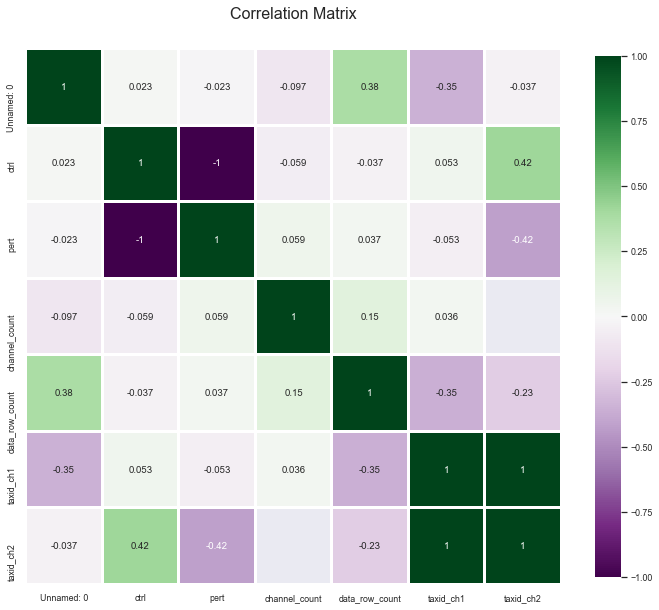

In [21]:

corr = train.corr()
plt.figure(figsize=(12, 12))
sns.set(font_scale=0.8)
sns.heatmap(corr, square=True, cmap="PRGn", linewidths=2, annot=True, cbar_kws={'shrink': 0.8})
plt.title("Correlation Matrix", fontsize=16, pad=30)
plt.show()

In [22]:
# Acquiring the text-based features
cols_text = []
for col, form in zip(df.columns, df.dtypes):
    if form == 'object': cols_text.append(col)
print(cols_text)

['characteristics_ch1', 'data_processing', 'description', 'extract_protocol_ch1', 'hyb_protocol', 'label_ch1', 'label_protocol_ch1', 'molecule_ch1', 'organism_ch1', 'platform_id', 'scan_protocol', 'source_name_ch1', 'title', 'type']


In [23]:
cols_text.remove('data_processing')
cols_text.remove('description')
cols_text.remove('platform_id')
cols_text.remove('scan_protocol')
cols_text.remove('title')
cols_text.remove('type')
cols_text.remove('label_protocol_ch1')
cols_text.remove('hyb_protocol')
print(cols_text)


['characteristics_ch1', 'extract_protocol_ch1', 'label_ch1', 'molecule_ch1', 'organism_ch1', 'source_name_ch1']


In [24]:
# Pre-Processing function for text-based features
def preprocess(data_df):
    data_df['cleaned'] = ''
    
    # Initializing Stopwords and Lemmatization objects
    stop_words = set(stopwords.words('english'))
    wordnet_lemm = WordNetLemmatizer()
    
    # Pattern to detect characters which are not alphabets or numbers so they can removed
    alpha_or_numeric = "[^a-zA-Z0-9- ]"
    
    for index, row in tqdm(data_df.iterrows(), total = data_df.shape[0]):
        sample = row['feature']
        
        # Replacing characters which are not alphabets or numbers with blank space and ...
        # ... changing text to lowercase. These two steps are for cleaning text data, ...
        # ... you can add more on top of this to make your data cleaner.
        pre_txt = re.sub(alpha_or_numeric, " ", sample)
        pre_txt = sample.lower()
        
        # Removing stop words and lemmatizing different words in preprocessed text ...
        # ... and making the final processed text
        sample_words = [wordnet_lemm.lemmatize(w) for w in pre_txt.split() \
            if w not in stop_words and len(w)>1]
        pre_proc_ver = ' '.join(sample_words)
        
        data_df.loc[index, 'cleaned'] = pre_proc_ver
    return data_df

In [25]:
# Processing the text-based features
df_text = df.loc[ : , cols_text]
df_text['feature'] = df.apply(lambda row: ' '.join([str(row[i]) for i in cols_text]), axis=1)
df_text = preprocess(pd.DataFrame(df_text))

# Removing the Unnecessary Features
df_text = pd.DataFrame(df_text['cleaned'])
df_text.head()

100%|██████████| 623/623 [00:00<00:00, 2016.06it/s]


,cleaned
0,facs sorting: cd44low/cd24high total rna extra...
1,facs sorting: unsorted total rna extracted usi...
2,facs sorting: cd44low/cd24high total rna extra...
3,facs sorting: cd44high/cd24low total rna extra...
4,tissue: human nasal polyp nasal fibroblast exp...


In [28]:

# Feature extraction with TFIDF Vectorizer. 
# The class needs stopwords as an input and uses punkt by default which we ... 
# ... downloaded when importing libraries.
 #stop_words= set(stopwords.words('english'))

vect = TfidfVectorizer(analyzer="word", preprocessor=None, stop_words='english', max_features=4000)

df_text = vect.fit_transform(df_text['cleaned'])
df = pd.DataFrame(df_text.toarray())
print(df.shape)

(623, 1071)


In [29]:
pca = PCA(n_components=.99, svd_solver='full')
df = pca.fit_transform(df)
print(df.shape)


(623, 161)


In [ ]:
##Training the Model

In [30]:
X_train, X_val, y_train, y_val = train_test_split(df, y_lab, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

print("Training F1-Score: ", f1_score(y_train, y_train_pred))
print("Validation F1-Score: ", f1_score(y_val, y_val_pred))


(498, 161) (125, 161) (498,) (125,)
Training F1-Score:  0.899795501022495
Validation F1-Score:  0.6991869918699187


In [31]:
# Running the Model on the entire Training Dataset
lr = LogisticRegression(solver='liblinear')
lr.fit(df, y_lab)
y_pred = lr.predict(df)
print("F1-Score: ", f1_score(y_lab, y_pred))

F1-Score:  0.858603066439523


In [ ]:
#Inferencing

In [32]:
test_df = pd.read_csv("data_only_test.csv")
test_df.drop(columns=cols_ele, axis=1, inplace=True)
test_df.drop(columns=cols_drop, axis=1, inplace=True)
print(test_df.shape)

test_text = test_df.loc[ : , cols_text]
test_text['feature'] = test_df.apply(lambda row: ' '.join([str(row[i]) for i in cols_text]), axis=1)
test_text = preprocess(pd.DataFrame(test_text))
test_text = pd.DataFrame(test_text['cleaned'])
test_text = vect.transform(test_text['cleaned'])
test_df = pd.DataFrame(test_text.toarray())
print(test_df.shape)

test_df = pca.transform(test_df)
print(test_df.shape)

(6070, 17)


100%|██████████| 6070/6070 [00:02<00:00, 2456.75it/s]


(6070, 1071)
(6070, 161)


In [33]:
# Importing the Sample Submission and Preparing the Submission
y_sub = pd.read_csv("sample_submission.csv")
y_test = lr.predict(test_df)
y_sub['ctrl'] = y_test
y_sub.to_csv("sub12.csv", index = False)